<a href="https://colab.research.google.com/github/edcalderin/Competencia_Puntaje_Recencia/blob/master/Competencia_Puntaje_Recencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA

*Restart environment after install the following modules*

In [4]:
!pip install googletrans==3.1.0a0
!pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 1.2 MB 8.7 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=5988617acd01e0cd4d1de86a394ccf364f18449a52ee59eaee3d4eb01ab0c17d
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
     |████████████████████████████████| 12.0 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
# For NLP
import spacy
import re
from googletrans import Translator
from nltk import SnowballStemmer

In [6]:
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing data

Getting training and test datasets from Drive.

In [131]:
# Train
PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
train = pd.read_csv(PREFIX+'/Train.csv')
test = pd.read_csv(PREFIX+'/Test.csv')

## Exploring

In [132]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [133]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [134]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [135]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 8.95999999999998, 'Scores')

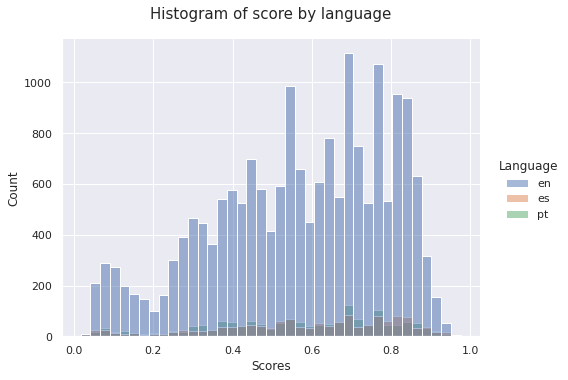

In [136]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

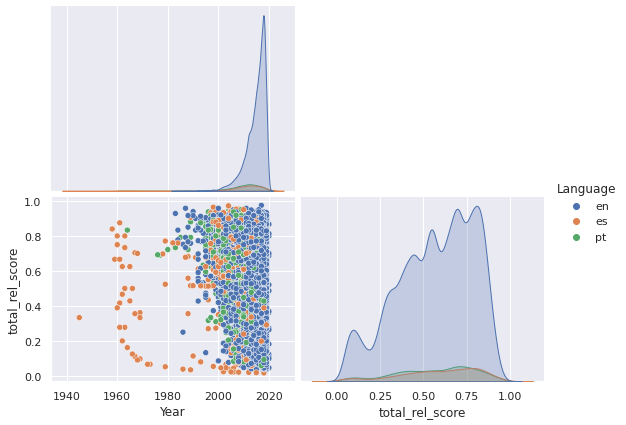

In [137]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [138]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [139]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [140]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [141]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


Dropping unnecessary columns:

In [142]:
COLS = ['id', 'Abstract', 'Title', 'Language']
train.drop(COLS, axis=1, inplace=True)

### Translating titles

In [ ]:
translator = Translator()
# Execute this cell in case of a previous tqdm execution. Tqdm sometimes prints progress in a new line.
while len(tqdm._instances) > 0:
    tqdm._instances.pop().close()
def translate_titles(df):
    titles = []
    %%time
    for item in tqdm(train[['Title','Language']].values):
        if item[1]=='en':
            titles.append(item[0])
        else:
            text = translator.translate(item[0], src=item[1]).text
            titles.append(text)
    return titles

In [ ]:
translator = Translator()
translator.translate('Los comuneros olvidados : la insurrección', src='es', dest='en').text

'Los comuneros olvidados : la insurrección'

In [ ]:
titles_translated = translate_titles(train)

  0%|          | 0/21456 [00:00<?, ?it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


100%|██████████| 21456/21456 [17:41<00:00, 20.22it/s]


In [ ]:
train['Title_translated'] = titles_translated

In [ ]:
titles_translated[21440]

'Los comuneros olvidados : la insurrección de 1781 en los llanos del Casanare'

In [ ]:
train[train.Language=='es']

,Language,Year,Title,total_rel_score,en,es,pt,Title_translated
15,es,0.880000,Vasculites e eosinófilos em biópsia endomiocár...,0.539815,0,1,0,Vasculites e eosinófilos em biópsia endomiocár...
23,es,0.640000,La taberna como cátedra,0.079894,0,1,0,La taberna como cátedra
28,es,0.880000,Feasibility of community-based health insuranc...,0.429816,0,1,0,Feasibility of community-based health insuranc...
68,es,0.706667,Los estigmas de un pueblo,0.054365,0,1,0,Los estigmas de un pueblo
93,es,0.960000,La lectura bonaventuriana de Aristóteles desde...,0.804000,0,1,0,La lectura bonaventuriana de Aristóteles desde...
...,...,...,...,...,...,...,...,...
21416,es,0.813333,Preparation of ZnO-SnO2 ceramic materials by a...,0.781250,0,1,0,Preparation of ZnO-SnO2 ceramic materials by a...
21421,es,0.986667,Una búsqueda de nuevas praxis en torno al uso...,0.292014,0,1,0,Una búsqueda de nuevas praxis en torno al uso...
21423,es,0.973333,"La eficiencia de la industria de alimentos, be...",0.388384,0,1,0,"La eficiencia de la industria de alimentos, be..."
21435,es,0.880000,Estenosis de venas pulmonares post ablación po...,0.700000,0,1,0,Estenosis de venas pulmonares post ablación po...


### Applying Natural Language Processing (NLP)

In [ ]:
nlp_en = spacy.load('en_core_web_sm')

In [ ]:
stemmer_en = SnowballStemmer(language='english')
stemmer_es = SnowballStemmer(language='spanish')
stemmer_pt = SnowballStemmer(language='portuguese')

#### Filtering words

Function to remove regular expressions, stopwords and filter some words.

In [ ]:
def get_filtered_docs(language, nlp_obj, stemmer_obj):
    '''
    language: 'en', 'es' or 'pt'
    nlp_obj: NLP object for every language
    '''
    filtered = []
    for title in train[train[language]==1].Title:
        # Regular expressions
        title_reg = re.sub(r'[^a-zA-Z_ÁÉÍÓÚáéíóúñÑ]+', ' ', title)
        tokens_list = [d.lemma_ for d in nlp_obj(title_reg)]
        # Filtering stopwords and len
        tokens_list = [word for word in tokens_list 
                       if not nlp_obj.vocab[word].is_stop and len(word)>2]
        tokens_list = [stemmer_obj.stem(word) for word in tokens_list]
        # Creating full sentence from word list
        filtered.append(' '.join(tokens_list))
    return filtered

Applying function to every language:

In [ ]:
%%time
filtered_en = get_filtered_docs('en', nlp_en, stemmer_en)
filtered_es = get_filtered_docs('es', nlp_es, stemmer_es)
filtered_pt = get_filtered_docs('pt', nlp_pt, stemmer_pt)

Removing Title column since we have got features:

In [ ]:
train.drop(['Title'], axis=1, inplace=True)

Some documents after removing stop words in each language:

In [ ]:
for title, corpus_lan in zip(['English', 'Spanish', 'Portuguese'], [filtered_en, filtered_es, filtered_pt]):
    print(title)
    for i, doc in enumerate(corpus_lan[60:64]):
        print(i, doc)
    print('---')

#### Vectorizing

Vectorizing resultant words with TfidfVectorizer from Sklearn. Notice the parameter strip_accent for removing accents and min_df to get terms with more than 5 document frequencies

In [ ]:
model_vectorizer_en = CountVectorizer(strip_accents='ascii', min_df=80, dtype='int8')
tfidf_values_en = model_vectorizer_en.fit_transform(filtered_en)

In [ ]:
MIN_DF = 15
model_vectorizer_es = CountVectorizer(strip_accents='ascii', min_df=MIN_DF, dtype='int8')
tfidf_values_es = model_vectorizer_es.fit_transform(filtered_es)

In [ ]:
model_vectorizer_pt = CountVectorizer(strip_accents='ascii', min_df=MIN_DF, dtype='int8')
tfidf_values_pt = model_vectorizer_pt.fit_transform(filtered_pt)

Inspecting dimensions:

In [ ]:
tfidf_en = tfidf_values_en.toarray()
tfidf_es = tfidf_values_es.toarray()
tfidf_pt = tfidf_values_pt.toarray()

In [ ]:
# Verifying number of rows
assert tfidf_en.shape[0] + tfidf_es.shape[0] + tfidf_pt.shape[0] == train.shape[0], 'Num rows does not match'

In [ ]:
print('Shape Tfidf English', tfidf_en.shape)
print('Shape Tfidf Spanish', tfidf_es.shape)
print('Shape Tfidf Portuguese', tfidf_pt.shape)

#### Appending Dataframes

Joining to train dataframe:

In [ ]:
# Creating dataframe for Tfidf english: Set by new features and training columns, same for the next cells.

df_tfidf_en = pd.DataFrame(tfidf_en, columns=model_vectorizer_en.get_feature_names())
train_en = train[train.en==1].reset_index(drop=True)
train_en = train_en.join(df_tfidf_en)

In [ ]:
df_tfidf_es = pd.DataFrame(tfidf_es, columns=model_vectorizer_es.get_feature_names())
train_es = train[train.es==1].reset_index(drop=True)
train_es = train_es.join(df_tfidf_es)

In [ ]:
df_tfidf_pt = pd.DataFrame(tfidf_pt, columns=model_vectorizer_pt.get_feature_names())
train_pt = train[train.pt==1].reset_index(drop=True)
train_pt = train_pt.join(df_tfidf_pt)

In [ ]:
%%time
train_with_tfidf = train_en.append(train_es).append(train_pt)

Checking shape and missing values:

In [ ]:
print('Shape -', train_with_tfidf.shape)
print('Nan values -', train_with_tfidf.isna().sum().sum())

To join these three dataframes caused multiple nan values, but it is normal because I am creating new Tfidf features for every language. Next, these missing values will be filled with zeros:

In [ ]:
train_with_tfidf.fillna(0, inplace=True)
print('Nan values -', train_with_tfidf.isna().sum().sum())

In [ ]:
train_with_tfidf.head()

¡Now, we are ready for training!

## Reduction of dimensionality - PCA

We got more than 1000 features in the new processed dataframe. It is time to reduce dimensionality in order to remove any redundance in data. Also, I do not know the optime number of components or dimensions that explain most of data. So, the only solution I can see is to iterate over number of features minus one for getting sum of variances in each of these components.

In [22]:
SEED = 42 # Random seed for PCA, Train test split and machine learning model

In [ ]:
variances = [] # This list will store the variances
n_components = np.arange(4, train_with_tfidf.shape[1], 30) # Range of componentes which I going to iterate on
for i in tqdm(n_components):
    pca = PCA(n_components=i, random_state=SEED)
    pca.fit(train_with_tfidf.drop(['total_rel_score'], axis=1))
    variances.append(pca.explained_variance_ratio_.sum())

100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Deciding the number of components...

In [ ]:
variances_array = np.array(variances)
THRESHOLD = .93
idx_first = np.argmax(variances_array>=THRESHOLD)
optime_variance = variances_array[idx_first]
optime_components = n_components[idx_first]

print('With a variance of {} the optime number of components is {}'
    .format(round(optime_variance, 2), optime_components))

With a variance of 0.94 the optime number of components is 394


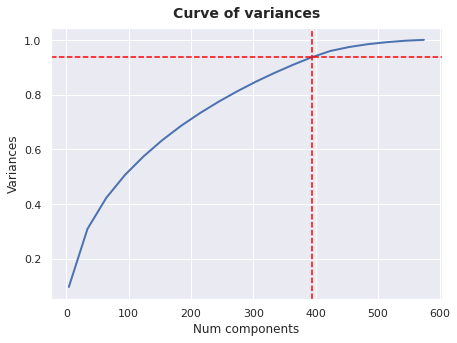

In [ ]:
sns.set()
plt.figure(figsize=(7, 5))
sns.lineplot(x=n_components, y=variances, lw=2)
plt.title('Curve of variances', fontsize=14, pad=10, fontweight='bold')
plt.xlabel('Num components')
plt.ylabel('Variances')
plt.axvline(optime_components, c='red', ls='--')
plt.axhline(optime_variance, c='red', ls='--')

In [ ]:
pca_train = PCA(n_components=optime_components, random_state=SEED)
data_pca = pca_train.fit_transform(train_with_tfidf.drop(['total_rel_score'], axis=1))
data_pca.shape

(21456, 394)

## Training

In [143]:
X = train.drop(['total_rel_score'], axis=1)
y = train.total_rel_score

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, shuffle=True)

Let's begin with a classic regressor 'Linear Regression' in order to find out our first score.

In [145]:
%%time
model = LinearRegression()
model.fit(X_train, y_train)

CPU times: user 3.72 ms, sys: 0 ns, total: 3.72 ms
Wall time: 3.74 ms


In [146]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

RMSLE Train 0.1462705315960809
RMSLE Test 0.1447294259917199


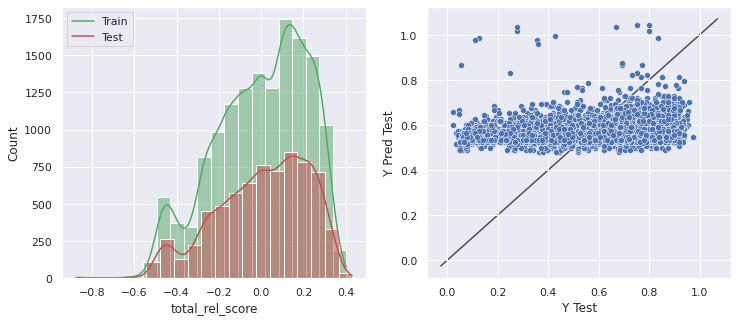

In [147]:
results_metric(model)

## Predictions

Preprocessing Test dataset

In [148]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [149]:
id = test.id

Removing same columns as train dataset:

In [150]:
test.drop(COLS, axis=1, inplace=True)

In [151]:
test.head()

,Year,en,es,pt
0,0.933333,1,0,0
1,0.906667,1,0,0
2,0.866667,1,0,0
3,0.813333,0,1,0
4,0.973333,1,0,0


In [153]:
y_pred = model.predict(test)
predictions = pd.DataFrame({'id':id, 'scototal_rel_score':y_pred})
predictions.head()

,id,scototal_rel_score
0,1,0.562744
1,2,0.581177
2,3,0.608826
3,4,0.618958
4,5,0.535095


In [154]:
predictions.to_csv(PREFIX+'/SampleSubmission.csv')